In [1]:
import glob
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from interactions import generate_interactions
from sklearn.preprocessing import StandardScaler

from adam import ADAM
from iwls import IWLS
from sgd import SGD
import os

In [2]:
folder_path = 'datasets'
csv_files = glob.glob(folder_path + '/*.csv')
dfs = {}
file_names = []

for file in csv_files:
    file_name = Path(file).stem
    file_names.append(file_name)
    dfs[file_name] = pd.read_csv(file)

print(file_names)

['nhanes_survey_age_prediction', 'mice_protein_expression', 'ajwa_or_medjool', 'mushroom_classification', 'obesity_levels', 'wine_color_classification', 'taiwanese_bankruptcy_prediction', 'fertility', 'room_occupancy_estimation']


In [3]:
max_epochs = 500
tolerance = 1e-4
test_size = 0.3
n_samples = 1000
n_features = 70
batch_size = 16
standarize = True

In [4]:
Xs = {}
ys = {}

Xs_train = {}
Xs_test = {}
ys_train = {}
ys_test = {}

for file_name in file_names:
    Xs[file_name] = dfs[file_name].drop(columns=['target']).values
    ys[file_name] = dfs[file_name]['target'].values
    
    Xs_train[file_name], Xs_test[file_name], ys_train[file_name], ys_test[file_name] = train_test_split(Xs[file_name], ys[file_name], test_size=0.2, random_state=69)
    
    if standarize:
        scaler = StandardScaler()
        Xs_train[file_name] = scaler.fit_transform(Xs_train[file_name])
        Xs_test[file_name] = scaler.transform(Xs_test[file_name])
    


In [5]:
from main import run_custom_optimizer_experiment
from main import run_pytorch_experiment
from main import run_classifier_experiment
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

/home/user/.local/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/user/.local/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/user/.local/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/user/.local/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/user/.local/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


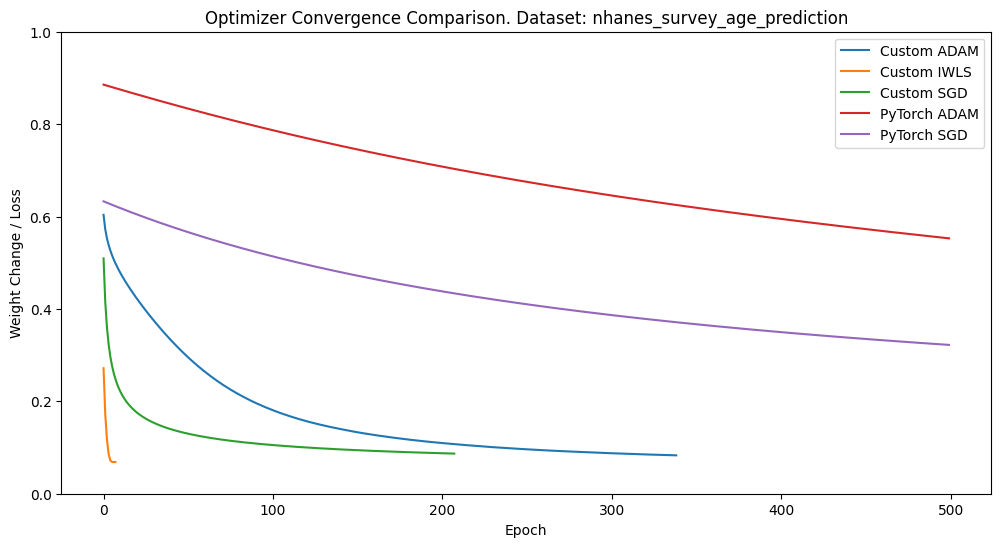

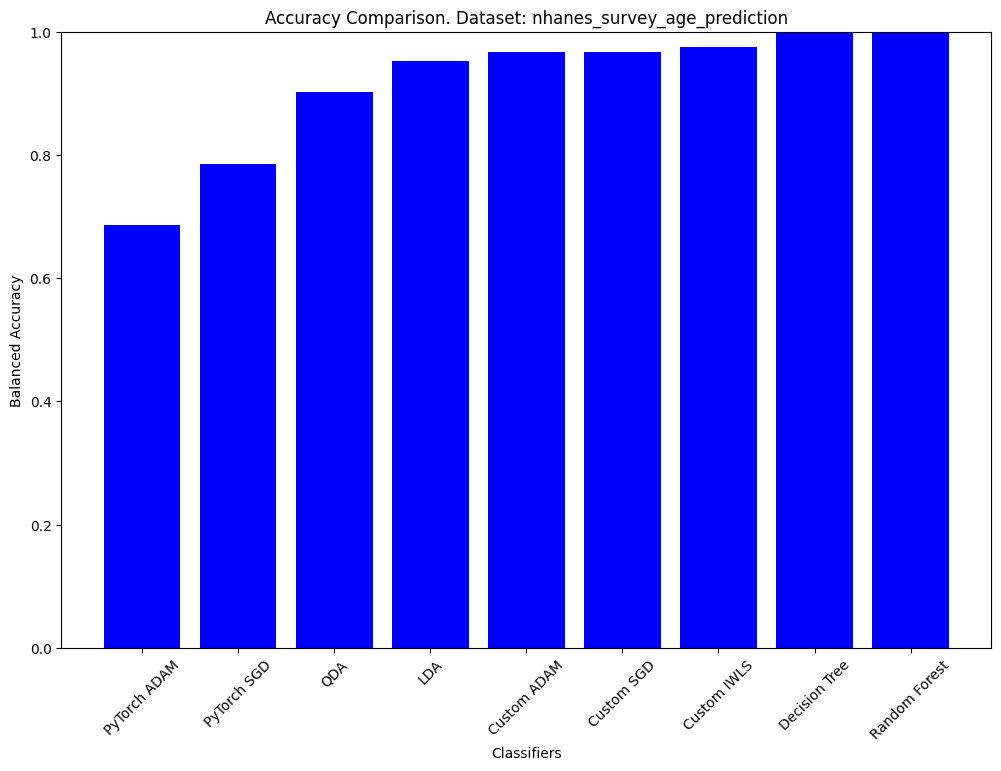

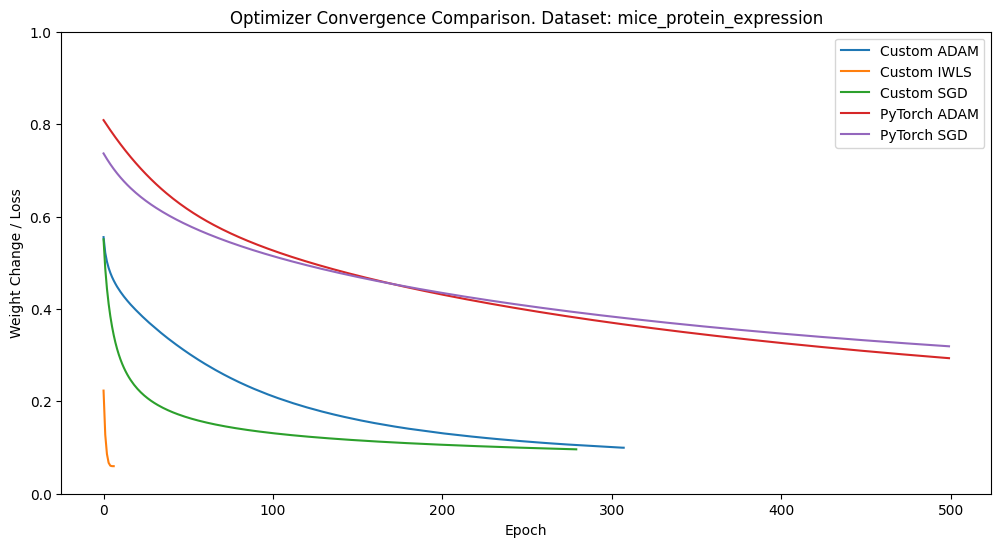

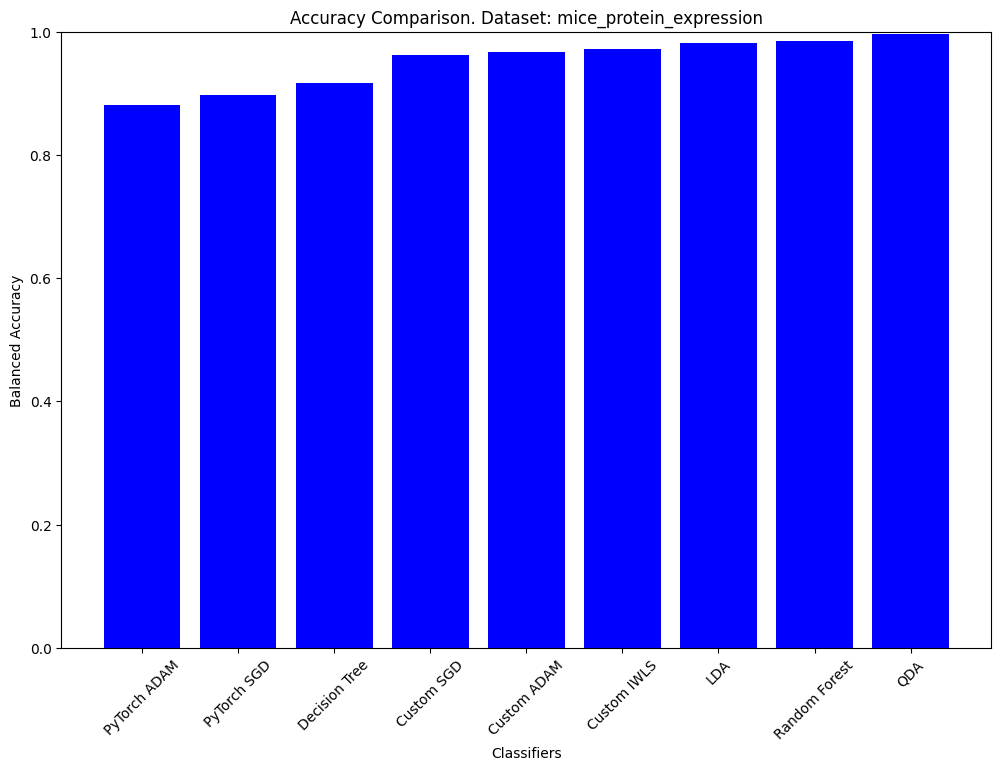

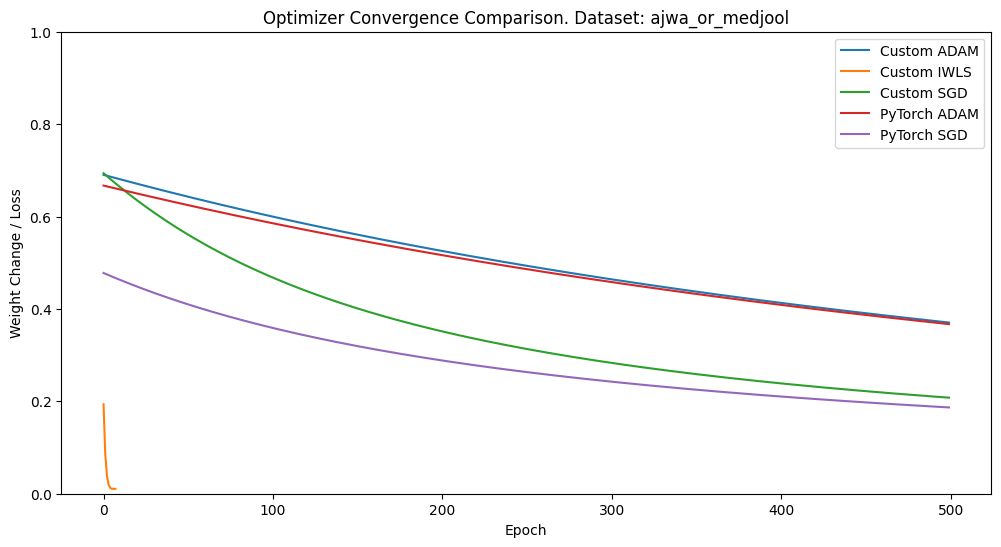

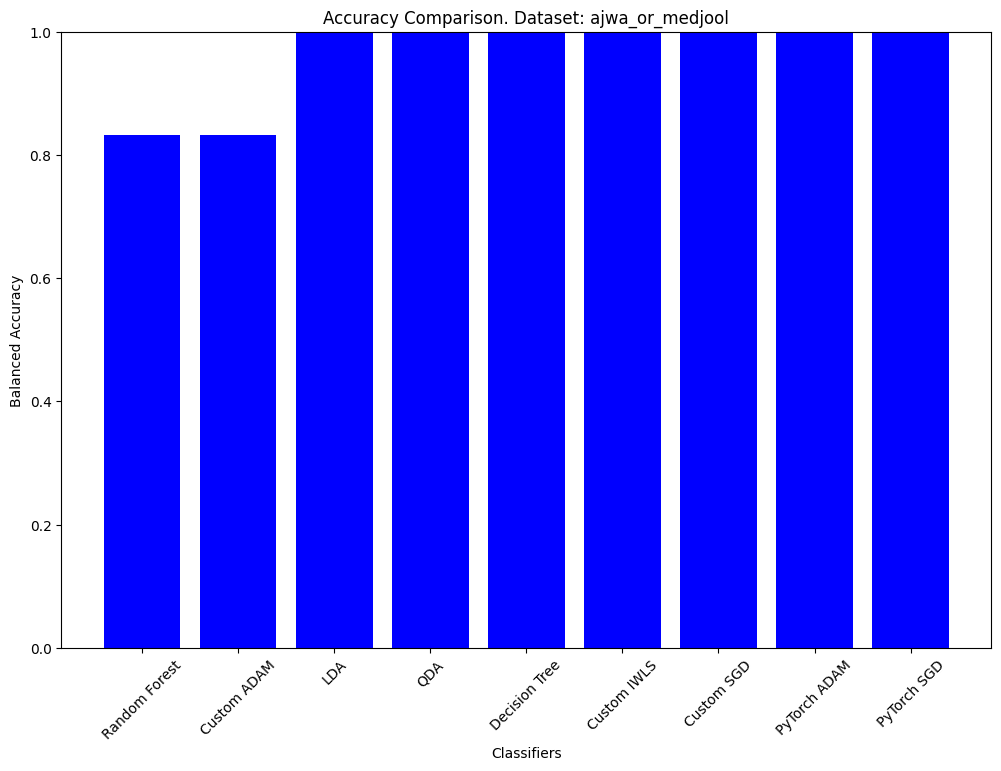

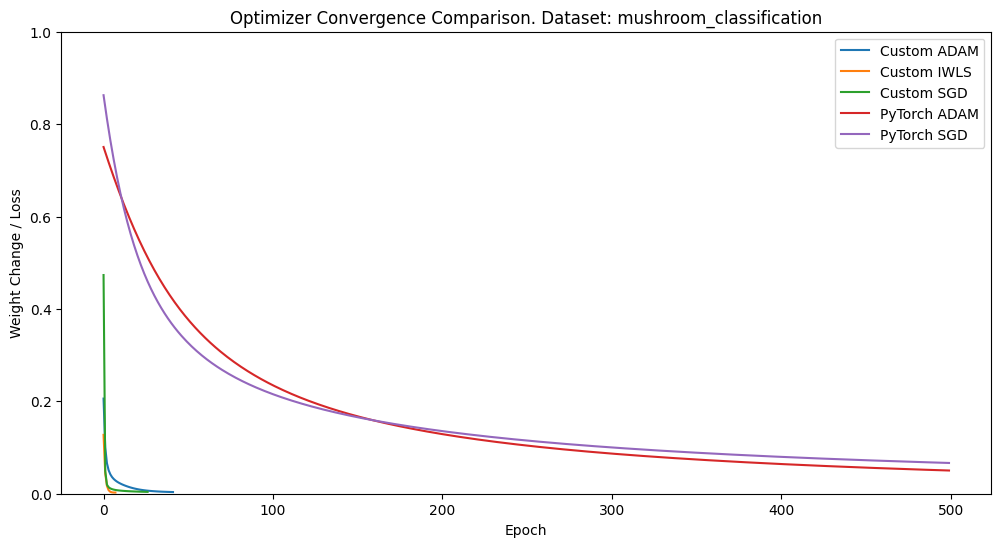

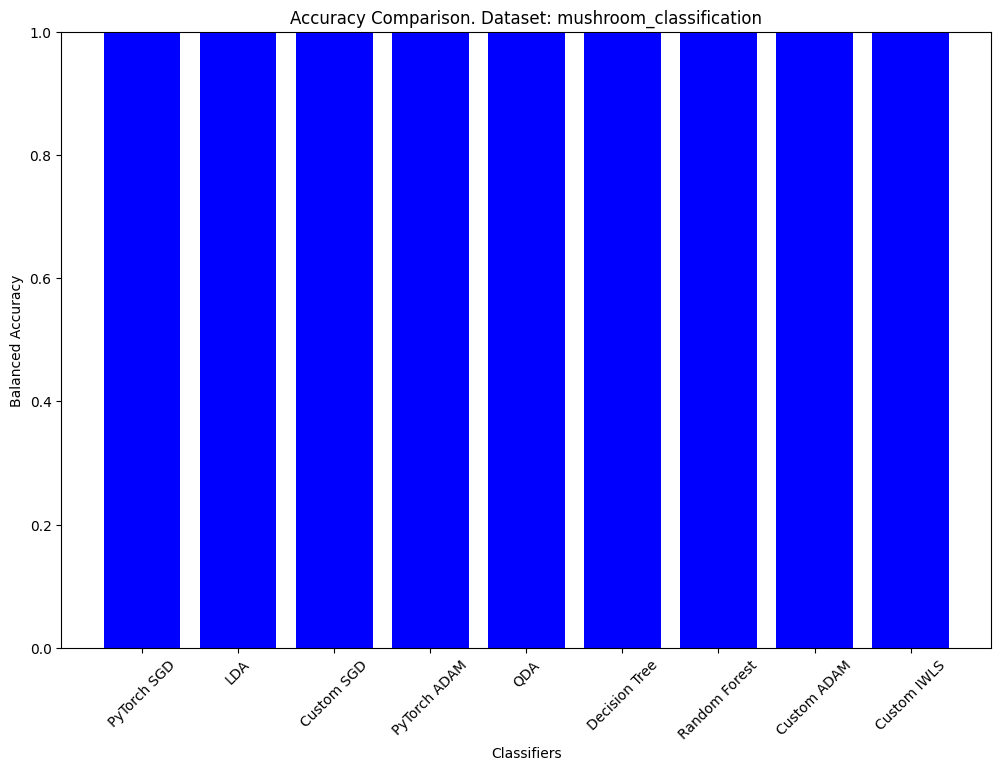

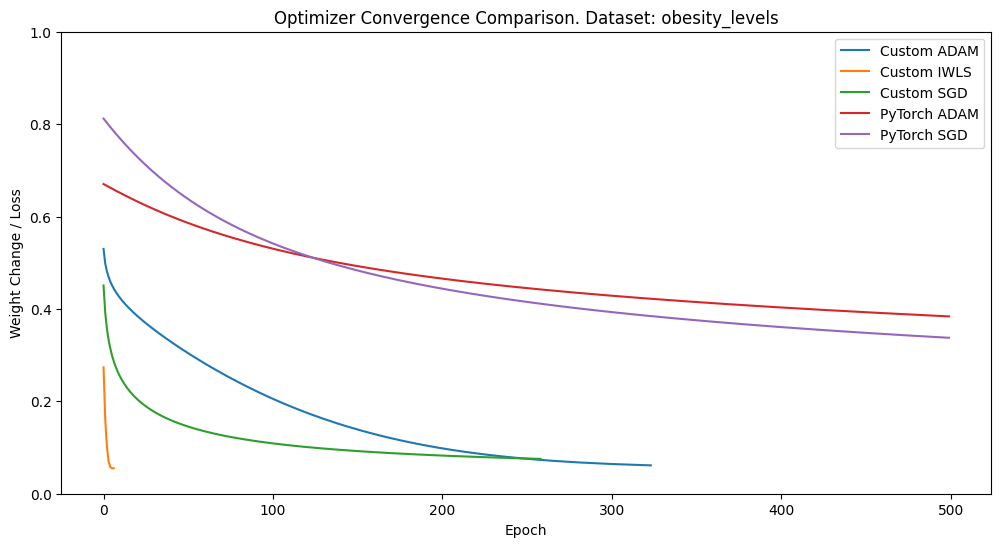

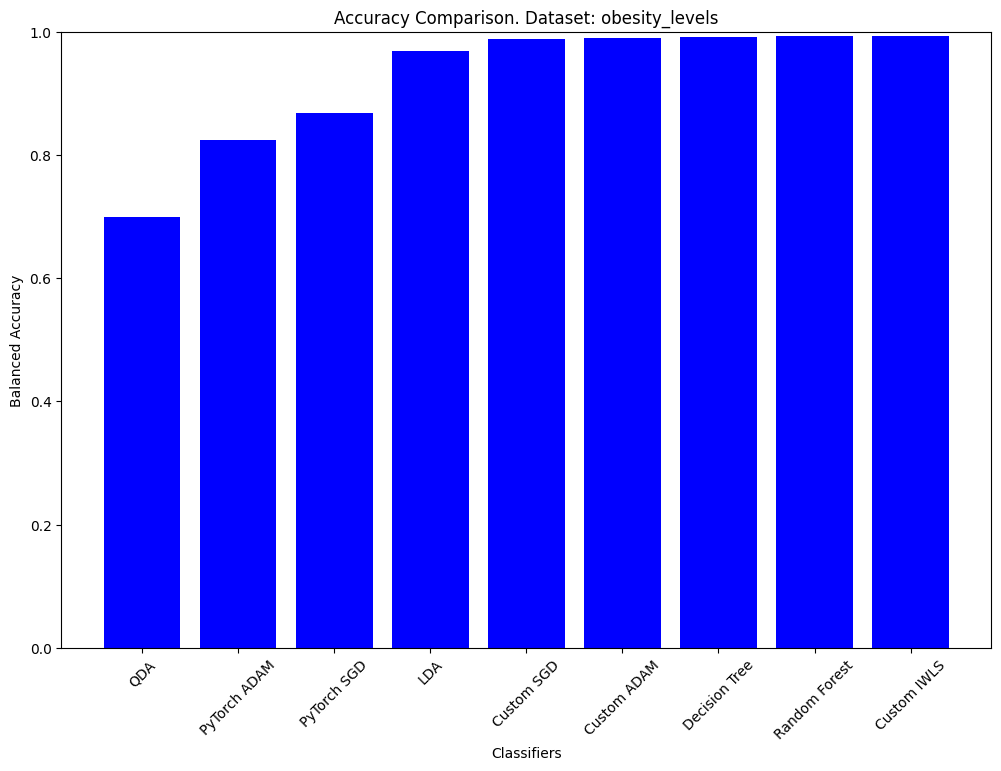

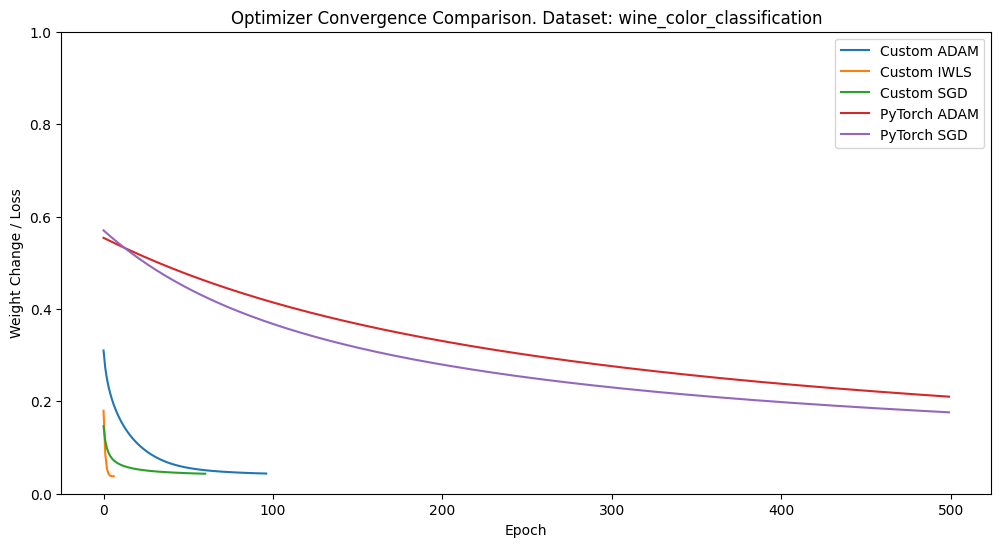

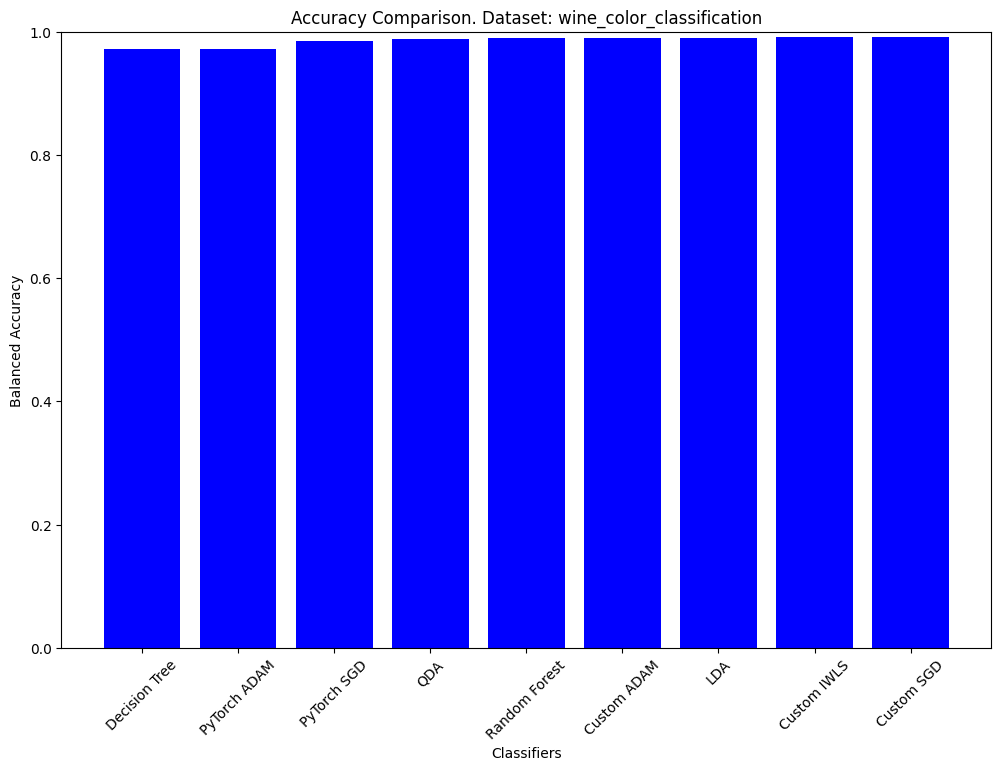

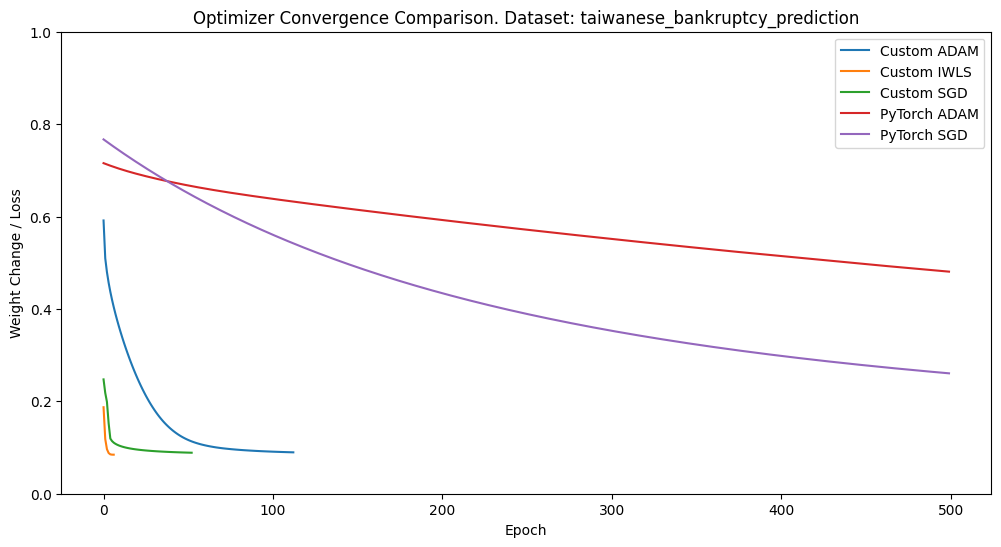

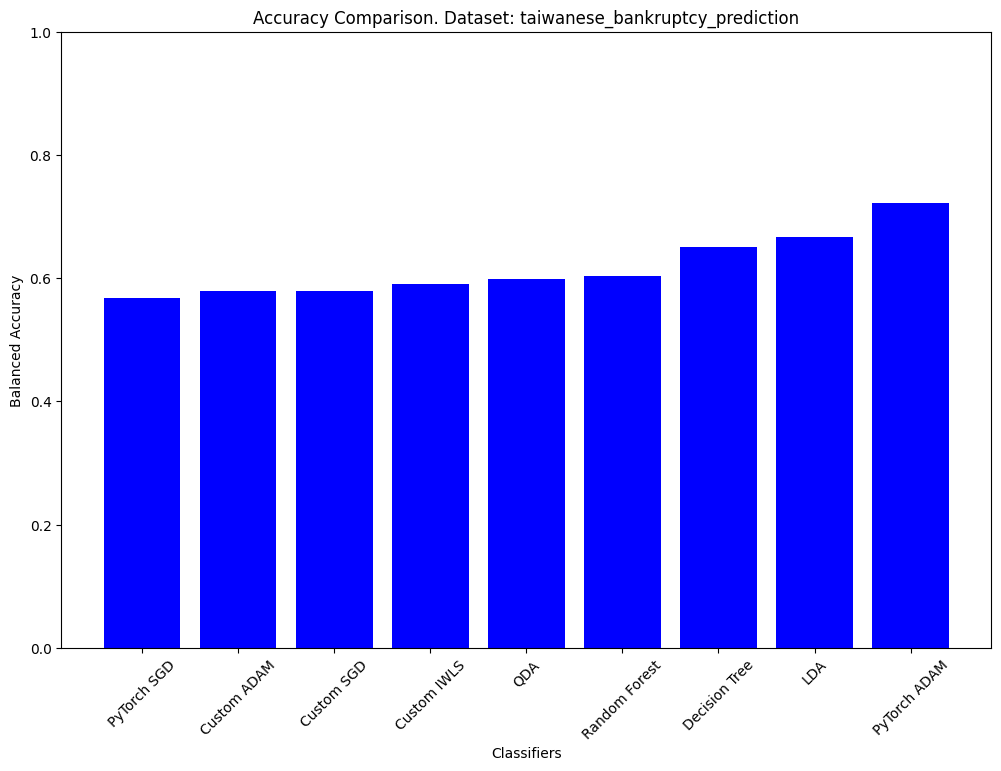

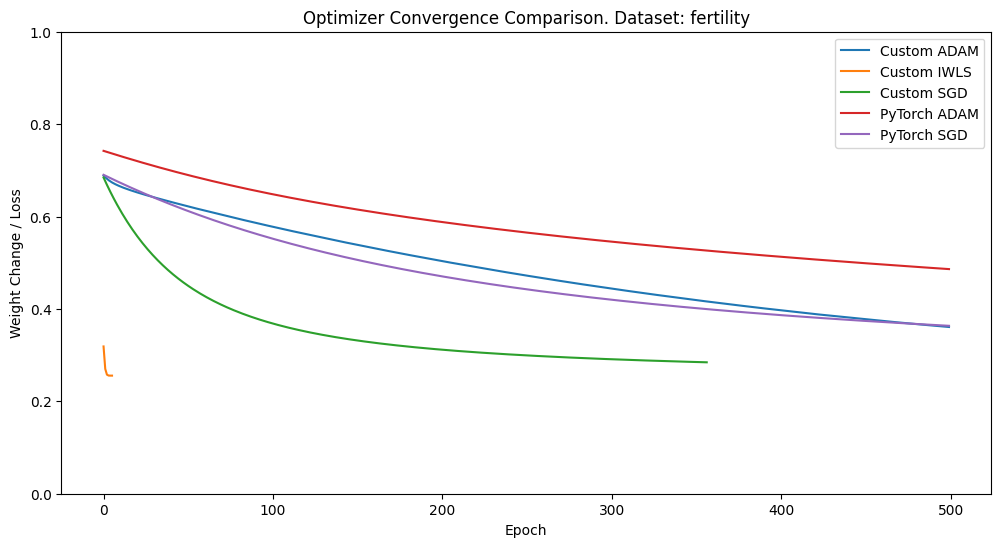

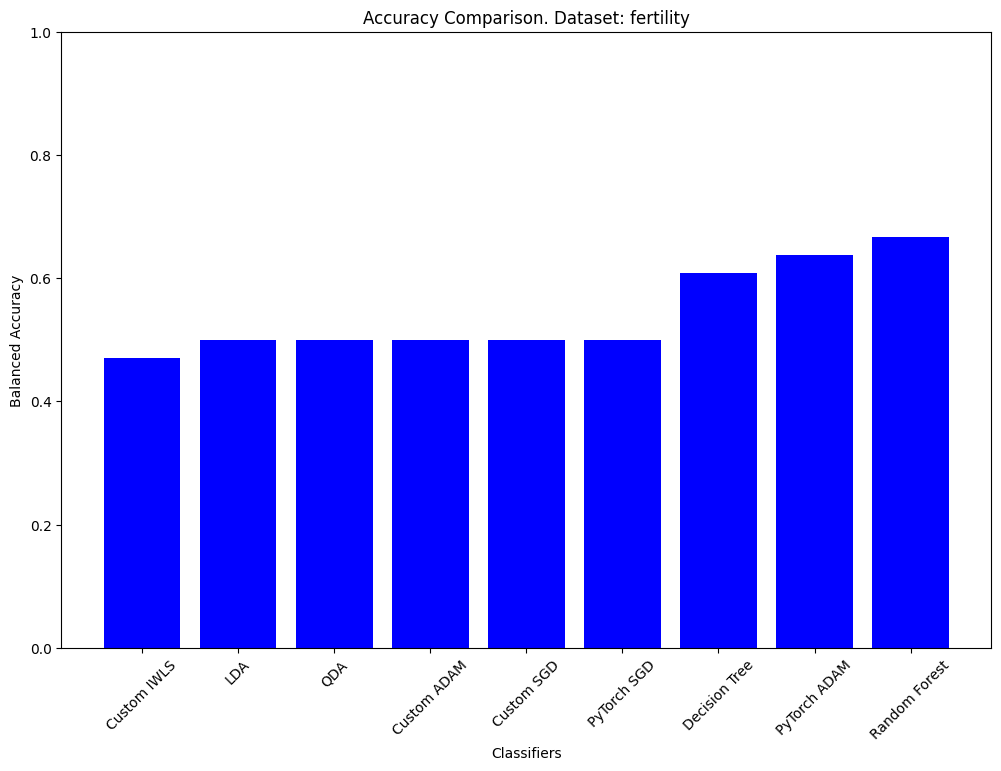

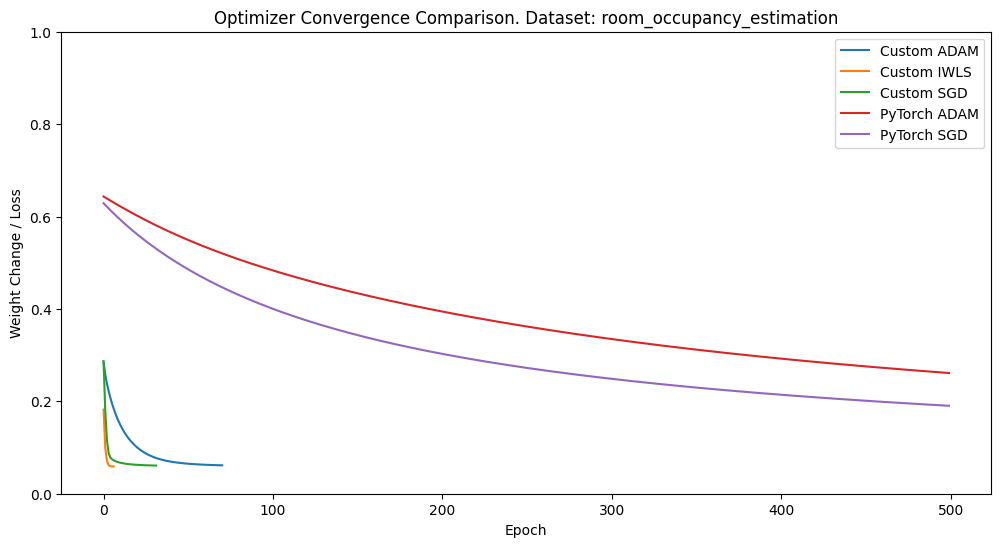

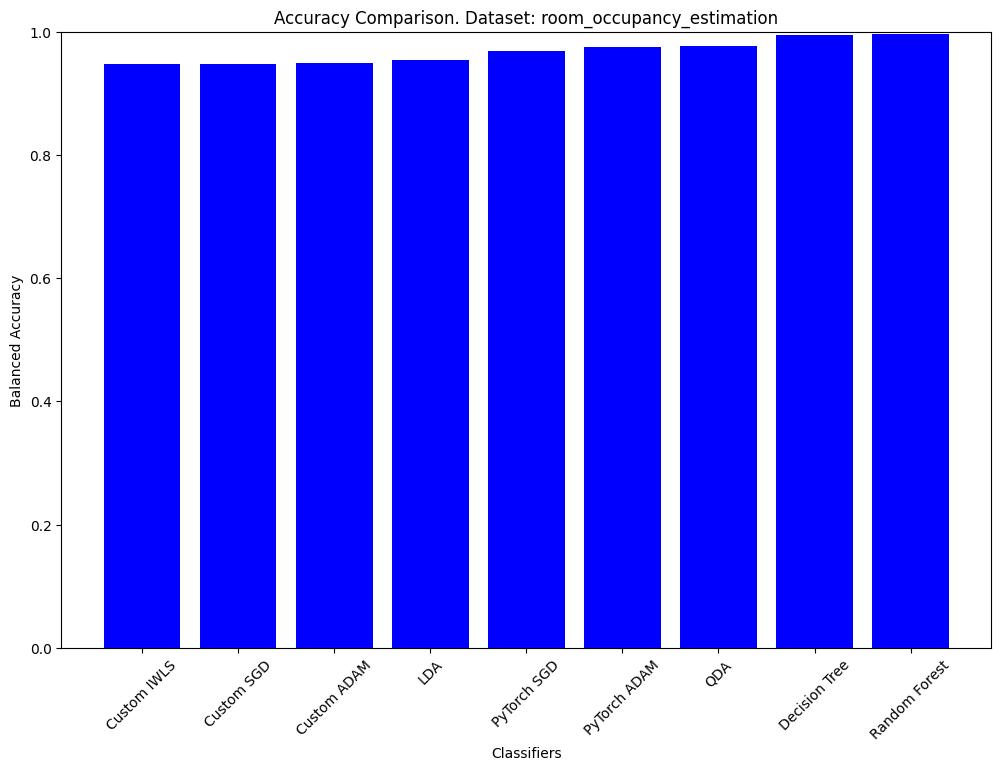

In [6]:
if not os.path.exists('outputs'):
    os.system('mkdir outputs')


for file_name in file_names:
    adam = ADAM(batch_size=batch_size)
    iwsl = IWLS()
    sgd = SGD(batch_size=batch_size)

    # Run experiments
    custom_adam_acc, adam_weight_changes = run_custom_optimizer_experiment(
        adam, Xs_train[file_name], ys_train[file_name], Xs_test[file_name], ys_test[file_name], tolerance, max_epochs
    )
    custom_iwls_acc, iwls_weight_changes = run_custom_optimizer_experiment(
        iwsl, Xs_train[file_name], ys_train[file_name], Xs_test[file_name], ys_test[file_name], tolerance, max_epochs
    )
    custom_sgd_acc, sgd_weight_changes = run_custom_optimizer_experiment(
        sgd, Xs_train[file_name], ys_train[file_name], Xs_test[file_name], ys_test[file_name], tolerance, max_epochs
    )

    pytorch_adam_acc, pytorch_adam_losses = run_pytorch_experiment(
        Xs_train[file_name], ys_train[file_name], Xs_test[file_name], ys_test[file_name], "adam", tolerance, max_epochs
    )
    pytorch_sgd_acc, pytorch_sgd_losses = run_pytorch_experiment(
        Xs_train[file_name], ys_train[file_name], Xs_test[file_name], ys_test[file_name], "sgd", tolerance, max_epochs
    )

    lda = LinearDiscriminantAnalysis()
    qda = QuadraticDiscriminantAnalysis()
    dt = DecisionTreeClassifier()
    rf = RandomForestClassifier()


    lda_accuracy = run_classifier_experiment(lda, Xs_train[file_name], ys_train[file_name], Xs_test[file_name], ys_test[file_name])
    qda_accuracy = run_classifier_experiment(qda, Xs_train[file_name], ys_train[file_name], Xs_test[file_name], ys_test[file_name])
    dt_accuracy = run_classifier_experiment(dt, Xs_train[file_name], ys_train[file_name], Xs_test[file_name], ys_test[file_name])
    rf_accuracy = run_classifier_experiment(rf, Xs_train[file_name], ys_train[file_name], Xs_test[file_name], ys_test[file_name])

    # Plot convergence
    plt.figure(figsize=(12, 6))
    plt.plot(adam_weight_changes, label="Custom ADAM")
    plt.plot(iwls_weight_changes, label="Custom IWLS")
    plt.plot(sgd_weight_changes, label="Custom SGD")
    plt.plot(pytorch_adam_losses, label="PyTorch ADAM")
    plt.plot(pytorch_sgd_losses, label="PyTorch SGD")

    plt.xlabel("Epoch")
    plt.ylabel("Weight Change / Loss")
    plt.ylim(0, 1)
    plt.title(f"Optimizer Convergence Comparison. Dataset: {file_name}")
    plt.legend()
    plt.savefig(f"outputs/{file_name}_converge.pdf")
    


    # Plot accuracy
    classifiers = ['LDA', 'QDA', 'Decision Tree', 'Random Forest',
                'Custom ADAM', 'Custom IWLS', 'Custom SGD',
                'PyTorch ADAM', 'PyTorch SGD']

    accuracies = [lda_accuracy, qda_accuracy, dt_accuracy, rf_accuracy,
                custom_adam_acc, custom_iwls_acc, custom_sgd_acc,
                pytorch_adam_acc, pytorch_sgd_acc]

    sorted_data = sorted(zip(classifiers, accuracies), key=lambda x: x[1], reverse=False)
    sorted_classifiers, sorted_accuracies = zip(*sorted_data)

    plt.figure(figsize=(12, 8))
    plt.bar(sorted_classifiers, sorted_accuracies, color='blue')
    plt.xlabel('Classifiers')
    plt.ylabel('Balanced Accuracy')
    plt.title(f"Accuracy Comparison. Dataset: {file_name}")
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.savefig(f"outputs/{file_name}_accur.pdf")



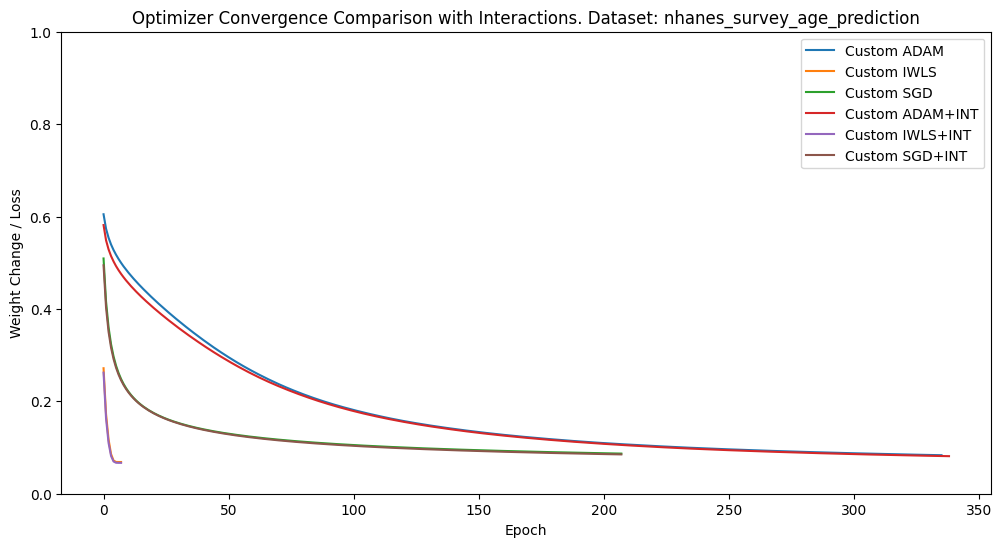

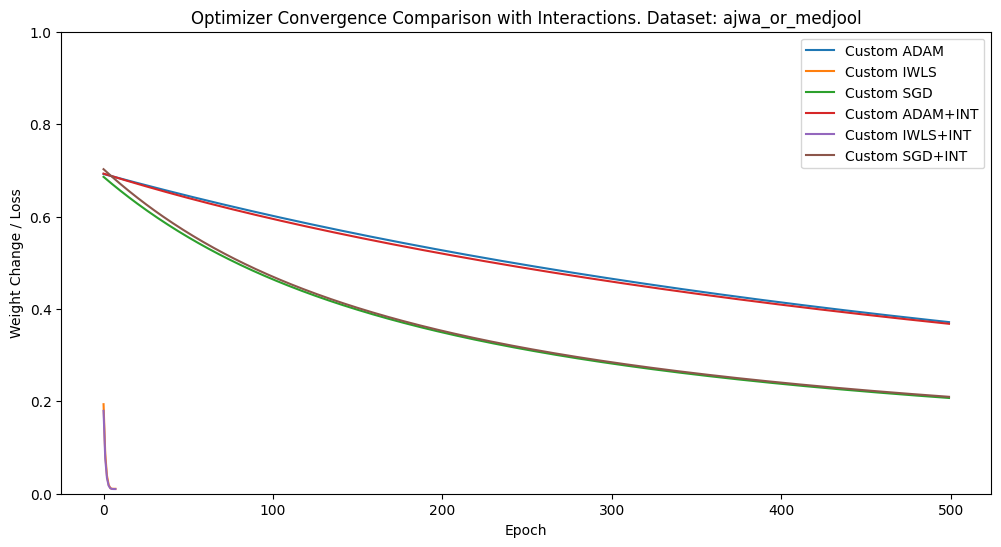

In [8]:

Xs_train_int = {}
Xs_test_int = {}
for file_name in file_names:
    if Xs[file_name].shape[1] > 10:
        continue
    adam = ADAM(batch_size=batch_size)
    iwsl = IWLS()
    sgd = SGD(batch_size=batch_size)

    # Run experiments
    custom_adam_acc, adam_weight_changes = run_custom_optimizer_experiment(
        adam, Xs_train[file_name], ys_train[file_name], Xs_test[file_name], ys_test[file_name], tolerance, max_epochs
    )
    custom_iwls_acc, iwls_weight_changes = run_custom_optimizer_experiment(
        iwsl, Xs_train[file_name], ys_train[file_name], Xs_test[file_name], ys_test[file_name], tolerance, max_epochs
    )
    custom_sgd_acc, sgd_weight_changes = run_custom_optimizer_experiment(
        sgd, Xs_train[file_name], ys_train[file_name], Xs_test[file_name], ys_test[file_name], tolerance, max_epochs
    )

    Xs_train_int[file_name] = generate_interactions(Xs_train[file_name])
    Xs_test_int[file_name] = generate_interactions(Xs_test[file_name])

    adam = ADAM(batch_size=batch_size)
    iwsl = IWLS()
    sgd = SGD(batch_size=batch_size)

    custom_adam_acc_int, adam_weight_changes_int = run_custom_optimizer_experiment(
        adam, Xs_train_int[file_name], ys_train[file_name], Xs_test_int[file_name], ys_test[file_name], tolerance, max_epochs
    )
    custom_iwls_acc_int, iwls_weight_changes_int = run_custom_optimizer_experiment(
        iwsl, Xs_train_int[file_name], ys_train[file_name], Xs_test_int[file_name], ys_test[file_name], tolerance, max_epochs
    )
    custom_sgd_acc_int, sgd_weight_changes_int = run_custom_optimizer_experiment(
        sgd, Xs_train_int[file_name], ys_train[file_name], Xs_test_int[file_name], ys_test[file_name], tolerance, max_epochs
    )

    # Plot convergence
    plt.figure(figsize=(12, 6))
    plt.plot(adam_weight_changes, label="Custom ADAM")
    plt.plot(iwls_weight_changes, label="Custom IWLS")
    plt.plot(sgd_weight_changes, label="Custom SGD")
    plt.plot(adam_weight_changes_int, label="Custom ADAM+INT")
    plt.plot(iwls_weight_changes_int, label="Custom IWLS+INT")
    plt.plot(sgd_weight_changes_int, label="Custom SGD+INT")

    plt.xlabel("Epoch")
    plt.ylabel("Weight Change / Loss")
    plt.ylim(0, 1)
    plt.title(f"Optimizer Convergence Comparison with Interactions. Dataset: {file_name}")
    plt.legend()
    plt.savefig(f"outputs/{file_name}_converge_interactions.pdf")